In [8]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from keras.utils import plot_model
from PIL import Image as pil_image

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
train_df = pd.read_csv("~/Downloads/humpback-whale-identification/train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [6]:
print("Preparing images")
X_train = np.zeros((train_df.shape[0], 128, 128, 3))
count = 0
    
for fig in train_df['Image']:
#load images into images of size 128x128x3
    img = image.load_img("train/"+fig, target_size=(128, 128, 3))
    x = image.img_to_array(img)
    x = preprocess_input(x)

    X_train[count] = x
    if (count%500 == 0):
        print("Processing image: ", count+1, ", ", fig)
    count += 1
X_train = X_train / 255.0
print(X_train.shape)

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  04c72257b.jpg
Processing image:  1001 ,  09cacb84d.jpg
Processing image:  1501 ,  0ef961892.jpg
Processing image:  2001 ,  141b56a1a.jpg
Processing image:  2501 ,  199a417aa.jpg
Processing image:  3001 ,  1ec170983.jpg
Processing image:  3501 ,  23f084b93.jpg
Processing image:  4001 ,  29163ad0b.jpg
Processing image:  4501 ,  2e0fab120.jpg
Processing image:  5001 ,  3347515d9.jpg
Processing image:  5501 ,  3842d71dc.jpg
Processing image:  6001 ,  3d7f4c7d5.jpg
Processing image:  6501 ,  425f763ca.jpg
Processing image:  7001 ,  4714400cd.jpg
Processing image:  7501 ,  4c082fbdf.jpg
Processing image:  8001 ,  50c683e23.jpg
Processing image:  8501 ,  560d986ad.jpg
Processing image:  9001 ,  5b68c83ed.jpg
Processing image:  9501 ,  60410f111.jpg
Processing image:  10001 ,  654951f81.jpg
Processing image:  10501 ,  6a572256c.jpg
Processing image:  11001 ,  6f96f55b6.jpg
Processing image:  11501 ,  74da2b511.jpg

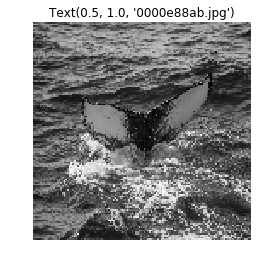

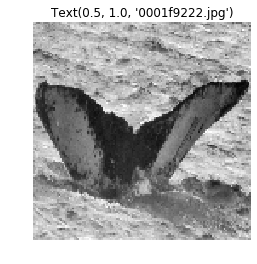

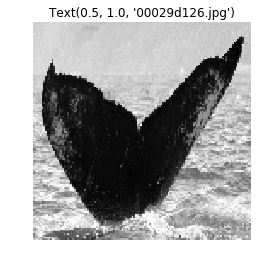

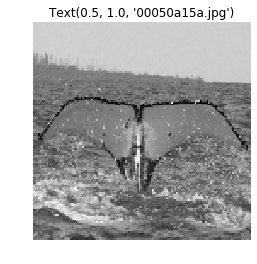

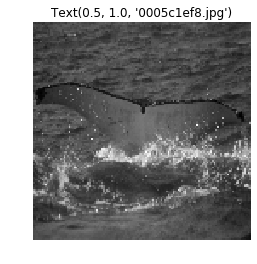

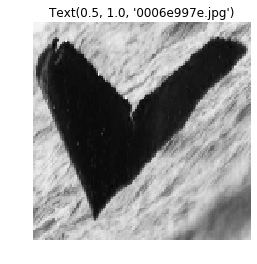

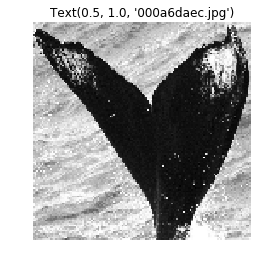

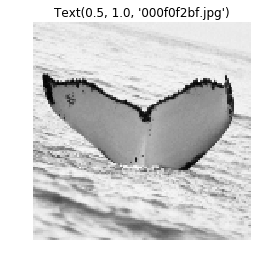

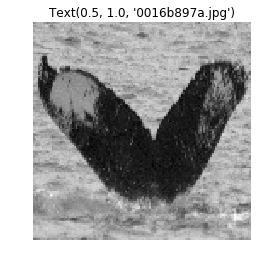

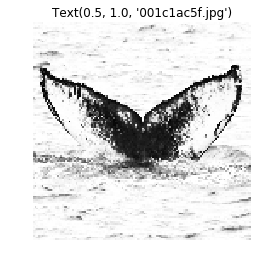

In [7]:
for i in range(10):
    plt.imshow(X_train[i][:,:,0], cmap="gray")
    plt.title(plt.title(train_df.iloc[i,0]))
    plt.axis("off")
    plt.show()

In [8]:
values = np.array(train_df['Id'])
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
# print(integer_encoded)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# print(onehot_encoded)
y = onehot_encoded
print(y.shape)

(25361, 5005)


## Distribution of images per whale is highly skewed.
2000+ whales have just one image

Single whale with most images have 73 of them

Images dsitribution:

- almost 30% comes from whales with 4 or less images
- almost 40% comes from 'new_whale' group
- the rest 30% comes from whales with 5-73 images

In [21]:
train_df['Id'].value_counts()[:4]

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
Name: Id, dtype: int64

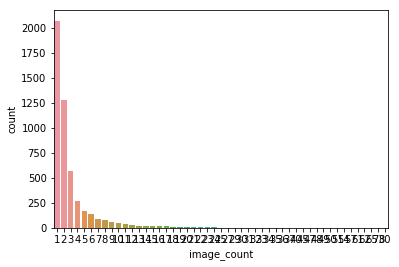

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


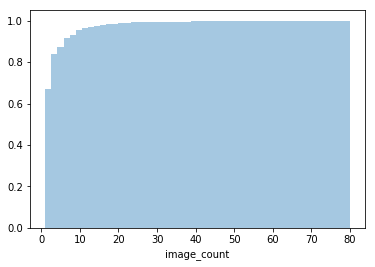

In [23]:
import seaborn as sns
counted = train_df.groupby("Id").count().rename(columns={"Image":"image_count"})
counted.loc[counted["image_count"] > 80,'image_count'] = 80
plt.figure()
sns.countplot(data=counted, x="image_count")
plt.show()
sns.distplot(counted["image_count"], norm_hist=True, kde=False, hist_kws={'cumulative': True})

This shows that 2000 of the 5K classes have only one image. About 1250 classes have 2 images, and so on.

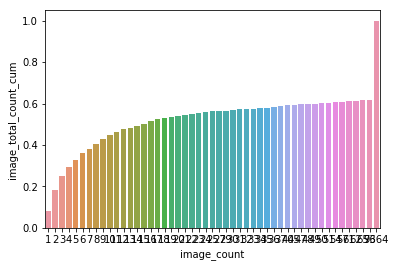

In [26]:
image_count_for_whale = train_df.groupby("Id", as_index=False).count().rename(columns={"Image":"image_count"})
whale_count_for_image_count = image_count_for_whale.groupby("image_count", as_index=False).count().rename(columns={"Id":"whale_count"})
whale_count_for_image_count['image_total_count'] = whale_count_for_image_count['image_count'] * whale_count_for_image_count['whale_count']
whale_count_for_image_count['image_total_count_cum'] = whale_count_for_image_count["image_total_count"].cumsum() / len(train_df)
sns.barplot(x='image_count',y='image_total_count_cum',data=whale_count_for_image_count)

In [27]:
whale_count_for_image_count[:5]

,image_count,whale_count,image_total_count,image_total_count_cum
0,1,2073,2073,0.081740
1,2,1285,2570,0.183076
2,3,568,1704,0.250266
3,4,273,1092,0.293324
4,5,172,860,0.327235


In [28]:
whale_count_for_image_count[-3:]

,image_count,whale_count,image_total_count,image_total_count_cum
46,65,1,65,0.616064
47,73,1,73,0.618942
48,9664,1,9664,1.000000


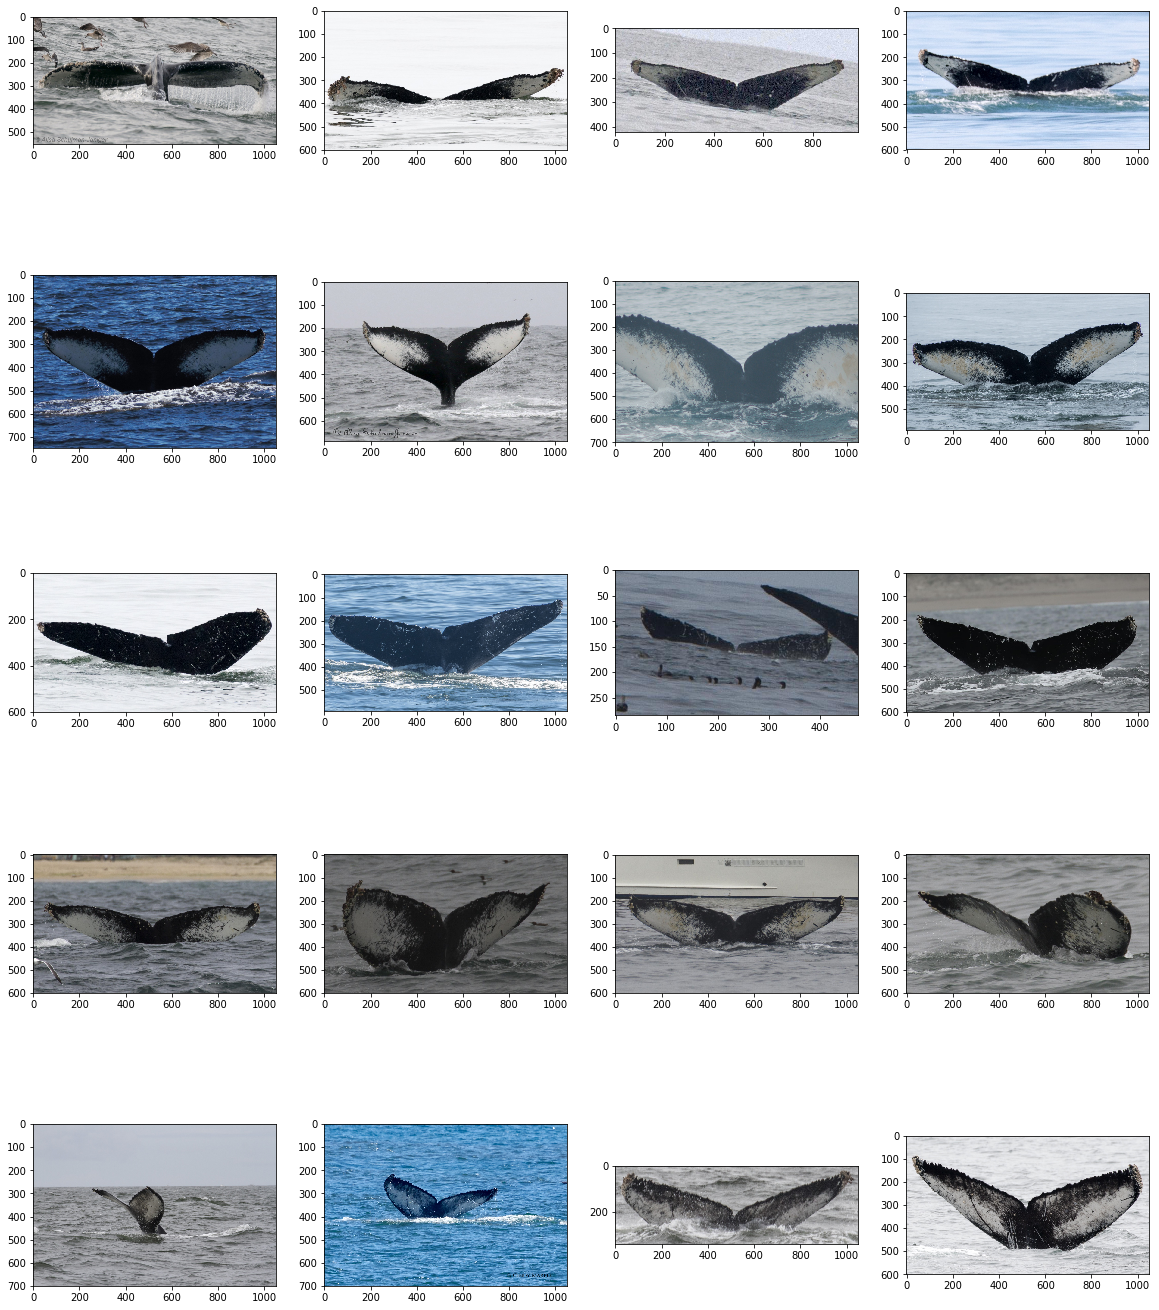

In [33]:
import cv2
topN=5
top_whales = train_df['Id'].value_counts().index[1:1+topN]
fig = plt.figure(figsize = (20, 5*topN))

for widx, whale in enumerate(top_whales):
    for idx, img_name in enumerate(train_df[train_df['Id'] == whale]['Image'][:4]):
        axes = widx*4 + idx+1
        y = fig.add_subplot(topN, 4, axes)
        img = cv2.imread(os.path.join("","train",img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        y.imshow(img)

plt.show()

over 7000 unique resolutions but 39 most popular cover ~45% images (both in train and in test)

In [5]:
import collections
import os
from PIL import Image
imageSizes_train = collections.Counter([Image.open(f'train/{filename}').size
                        for filename in os.listdir(f"train")])
imageSizes_test = collections.Counter([Image.open(f'test/{filename}').size
                        for filename in os.listdir(f"test")])

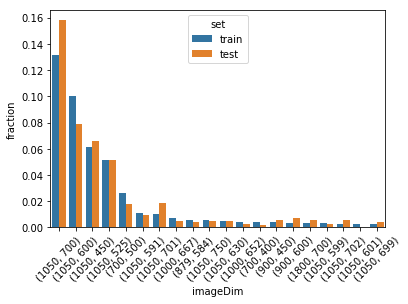

In [11]:
import seaborn as sns
def isdf(imageSizes):
    imageSizeFrame = pd.DataFrame(list(imageSizes.most_common()),columns = ["imageDim","count"])
    imageSizeFrame['fraction'] = imageSizeFrame['count'] / sum(imageSizes.values())
    imageSizeFrame['count_cum'] = imageSizeFrame['count'].cumsum()
    imageSizeFrame['count_cum_fraction'] = imageSizeFrame['count_cum'] / sum(imageSizes.values())
    return imageSizeFrame

train_isdf = isdf(imageSizes_train)
train_isdf['set'] = 'train'
test_isdf = isdf(imageSizes_test)
test_isdf['set'] = 'test'

isizes = train_isdf.merge(test_isdf, how="outer", on="imageDim")
isizes['total_count'] = isizes['count_x'] + isizes['count_y']
dims_order = isizes.sort_values('total_count', ascending=False)[['imageDim']]
len(dims_order)
isizes = pd.concat([train_isdf, test_isdf])
popularSizes = isizes[isizes['fraction'] > 0.002]
popularSizes.groupby('set').max()['count_cum_fraction']
sns.barplot(x='imageDim',y='fraction',data = popularSizes, hue="set")
_ = plt.xticks(rotation=45)

# Siamese Neural Network

In [26]:
from keras import regularizers
from keras.optimizers import Adam
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from keras.models import Model

img_shape    = (384,384,1) # The image shape used by the model

def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # no activation # Restore the number of original features
    y = Add()([x,y]) # Add the bypass connection
    y = Activation('relu')(y)
    return y

def build_model(lr, l2, activation='sigmoid'):

    ##############
    # BRANCH MODEL
    ##############
    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=img_shape) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x) # 48x48x128
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x) # 24x24x256
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) # 12x12x384
    for _ in range(4): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) # 6x6x512
    for _ in range(4): x = subblock(x, 128, **kwargs)
    
    x             = GlobalMaxPooling2D()(x) # 512
    branch_model  = Model(inp, x)
    
    ############
    # HEAD MODEL
    ############
    mid        = 32
    xa_inp     = Input(shape=branch_model.output_shape[1:])
    xb_inp     = Input(shape=branch_model.output_shape[1:])
    x1         = Lambda(lambda x : x[0]*x[1])([xa_inp, xb_inp])
    x2         = Lambda(lambda x : x[0] + x[1])([xa_inp, xb_inp])
    x3         = Lambda(lambda x : K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4         = Lambda(lambda x : K.square(x))(x3)
    x          = Concatenate()([x1, x2, x3, x4])
    x          = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x          = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x          = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x          = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x          = Flatten(name='flatten')(x)
    
    # Weighted sum implemented as a Dense layer.
    x          = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a      = Input(shape=img_shape)
    img_b      = Input(shape=img_shape)
    xa         = branch_model(img_a)
    xb         = branch_model(img_b)
    x          = head_model([xa, xb])
    model      = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model

model, branch_model, head_model = build_model(64e-5,0)
head_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512)          0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_2[0][0]                    
          

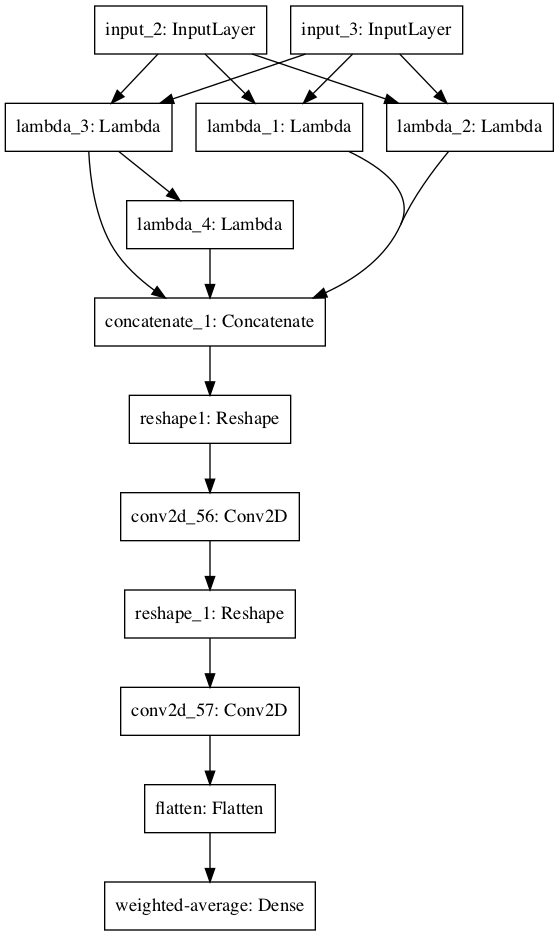

In [27]:
plot_model(head_model, to_file='head-model.png')
pil_image.open('head-model.png')

In [28]:
branch_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 64) 5248        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 96, 96, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 64)   256         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

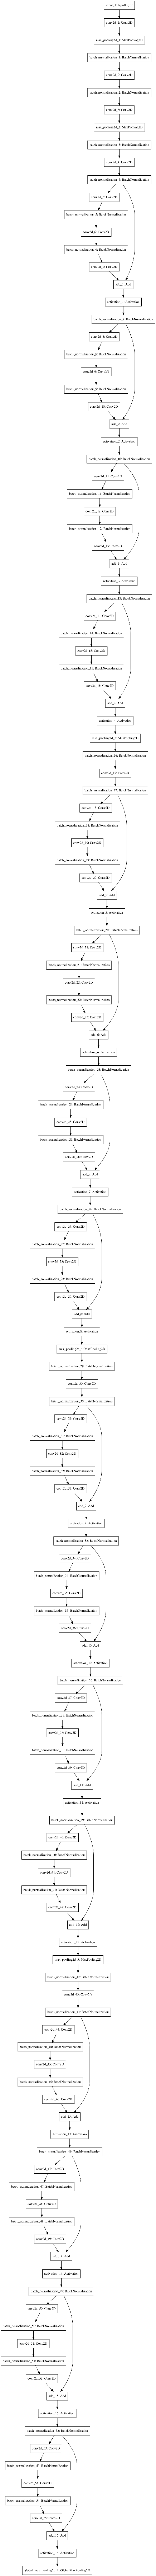

In [29]:
plot_model(branch_model, to_file='branch-model.png')
img = pil_image.open('branch-model.png')
img.resize([x//2 for x in img.size])